# RLify Getting started
In this file we will see examples of running differnet agent-algorithms, getting the train metric, and watching the agents in actions.


In [1]:
%matplotlib inline
from rlify.agents.dqn_agent import DQN_Agent
from rlify.agents.ppo_agent import PPO_Agent
from rlify.models import fc, rnn
from rlify import utils
import gymnasium as gym
device = utils.init_torch() #default goes to cuda -> cpu' or enter manualy

2023-09-25 15:27:31.161436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 15:27:32.039350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Example 1 - Train using discrete PPO
lets train a LunaLander gym env

In [2]:
env_name = "LunarLander-v2"
env = gym.make(env_name, render_mode=None)
model_class = fc.FC  # The backbone neural network
model_kwargs = {'embed_dim': 64, 'repeat':2}  # the chosen neural network args
agent = PPO_Agent(obs_space=env.observation_space, action_space=env.action_space, device=device, batch_size=1024, max_mem_size=10**5,
                num_parallel_envs=4, lr=3e-4, entropy_coeff=0.05, model_class=model_class, model_kwargs=model_kwargs, discount_factor=0.99, kl_div_thresh=0.05, clip_param=0.2)
train_stats = agent.train_n_steps(env=env,n_steps=350000)
# Saving the agent ckpt is easy
_ = agent.save_agent('lunar_ppo.pt')

episode 648, R:00053.31, total_steps:352570: : 352570it [03:23, 1733.63it/s]                          


### Plot rewards collected

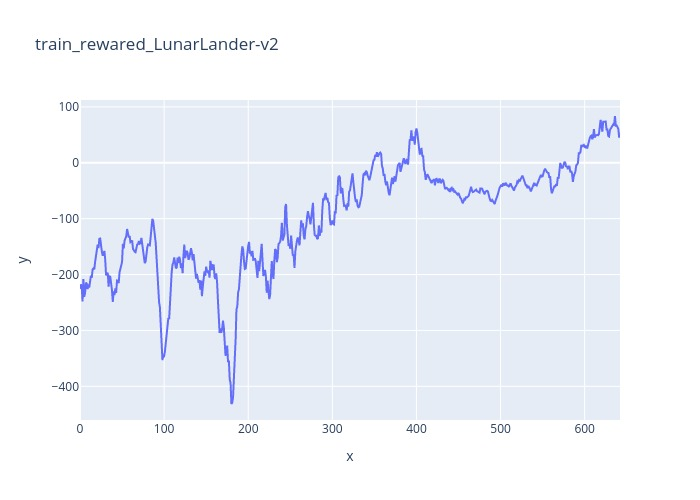

In [3]:
utils.plot_res(train_stats, 'train_rewared_'+env_name, smooth_kernel=10, render_as='jpg') #supports notebook, browser as well

### Lets see our agent in action

In [4]:
# Loading the agent ckpt is easy
agent.load_agent("lunar_ppo.pt")
env2 = gym.make("LunarLander-v2", render_mode="human")
mean_reward = agent.run_env(env2, best_act=True, num_runs=1)
print("Run Reward:", mean_reward)

Run Reward: [169.13942249]


## Example 2 - Lets use DQN now.
On CartPole

In [5]:
env_name = "CartPole-v1"
env_c = gym.make(env_name, render_mode=None)
model_class_c = fc.FC  # The backbone neural network
model_kwargs_c = {'embed_dim': 64, 'repeat':2}  # the chosen neural network args
agent_c = DQN_Agent(obs_space=env_c.observation_space, action_space=env_c.action_space, batch_size=64, max_mem_size=10**5, num_parallel_envs=16,
                     lr=3e-4, model_class=model_class_c, model_kwargs=model_kwargs_c, discount_factor=0.99, target_update='hard[update_freq=10]', tensorboard_dir = None)
train_stats_c = agent_c.train_n_steps(env=env_c,n_steps=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

episode 1680, R:00272.88, total_steps:103139: : 103139it [01:24, 1224.91it/s]                         


### Plot rewards collected

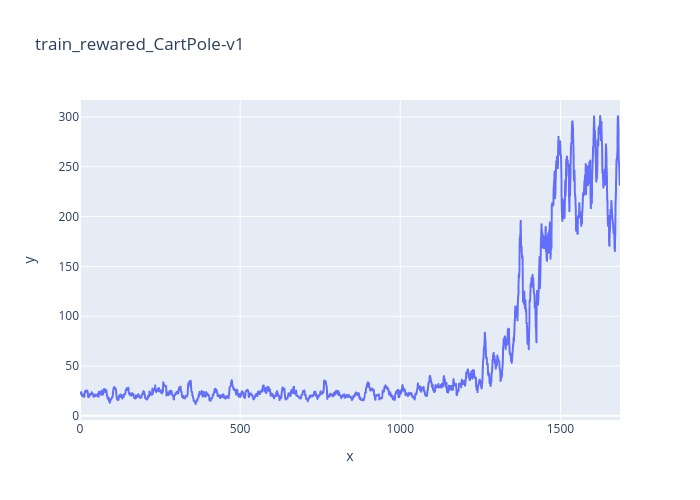

In [6]:
utils.plot_res(train_stats_c, 'train_rewared_'+env_name, smooth_kernel=10, render_as='jpg')

### Get the metrics for out train - notice that all the metrics are also stored under ./tensorboard dir

In [7]:
metric_df = agent_c.get_train_metrics()
metric_df.plot(backend='plotly')

### Check Our Agent

In [8]:
env_c2 = gym.make(env_name, render_mode="human")
reward = agent_c.run_env(env_c2, best_act=True)
print("Run Reward:", reward)

Run Reward: [233.]


## Example 3 -  Lets check a reccurent policy using simple GRU

In [9]:
env_name = "CartPole-v1"
env = gym.make(env_name, render_mode=None)
# this time we will use a simple GRU as our reccurent NN:
model_class = rnn.GRU            
model_kwargs = {'hidden_dim': 64, 'num_grus':2}
agent = PPO_Agent(obs_space=env.observation_space, action_space=env.action_space, device=device, batch_size=1024, max_mem_size=10**6, num_parallel_envs=32,
                   lr=3e-4, entropy_coeff=0.05, model_class=model_class, model_kwargs=model_kwargs, discount_factor=0.99, tensorboard_dir = None)
train_stats = agent.train_n_steps(env=env,n_steps=200000)

episode 1728, R:00205.91, total_steps:204515: : 204515it [02:41, 1265.81it/s]                          


### Plot rewards collected

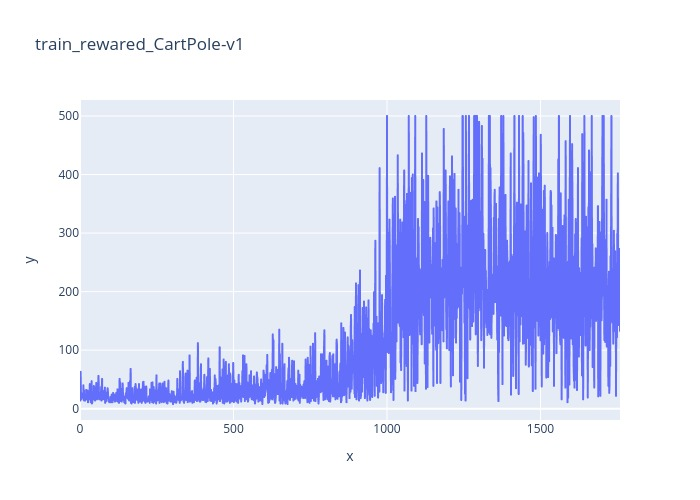

In [10]:
utils.plot_res(train_stats, 'train_rewared_'+env_name, smooth_kernel=1, render_as='jpg') #supports browser as well

### Check Our Agent

In [11]:
env_c2 = gym.make(env_name, render_mode="human")
reward = agent.run_env(env_c2, best_act=True, num_runs=1)
print("Run Reward:", reward)

Run Reward: [267.]


## Example 4 - A continuous action space

In [12]:
# env_name = "LunarLanderContinuous-v2"
env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode=None)
model_class = fc.FC  # The backbone neural network
model_kwargs = {'embed_dim': 128, 'repeat':3}  # the chosen neural network args
agent = PPO_Agent(obs_space=env.observation_space, action_space=env.action_space, device=device, batch_size=1024, max_mem_size=10**5,
                   num_parallel_envs=4, lr=3e-4, entropy_coeff=0.05, model_class=model_class, model_kwargs=model_kwargs, discount_factor=0.99, tensorboard_dir = None)
train_stats = agent.train_n_steps(env=env,n_steps=250000)

episode 1248, R:-00178.1, total_steps:250400: : 250400it [02:49, 1478.22it/s]                          


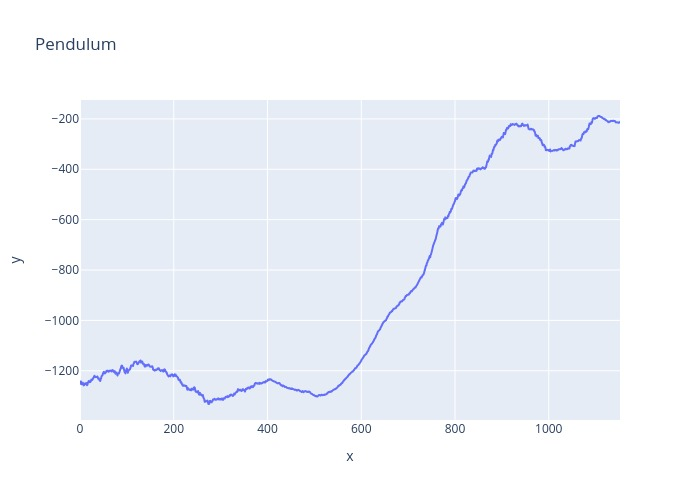

In [13]:
utils.plot_res(train_stats, "Pendulum", 100, render_as='jpg')

In [14]:
env_c2 = gym.make(env_name, render_mode="human")
reward = agent.run_env(env_c2, best_act=True, num_runs=1)
print("Run Reward:", reward)

Run Reward: [-121.80017378]
